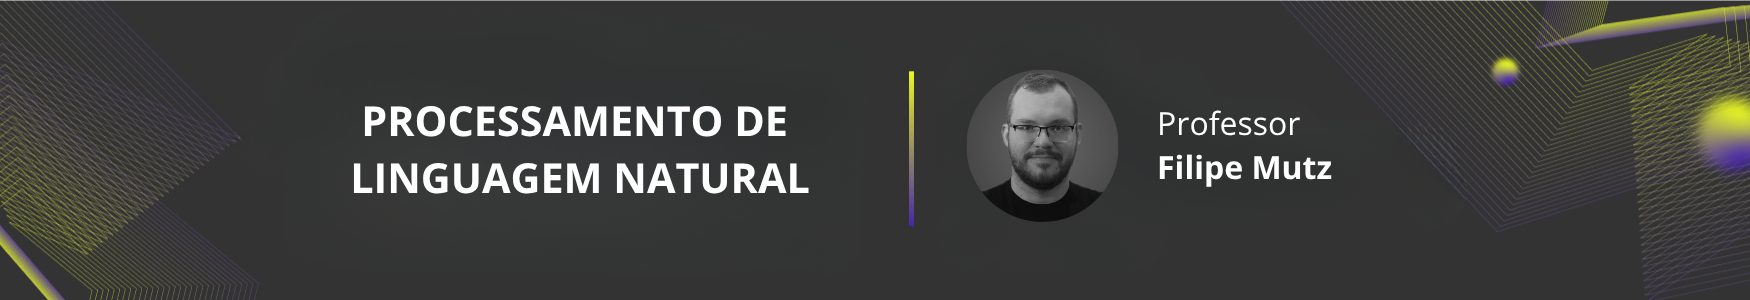

# 📝🤖 Tradução usando LSTMs Seq2Seq

Este notebook tem como objetivo demonstrar como utilizar uma arquitetura **Sequence-to-Sequence (Seq2Seq)** para tradução.

Ela consiste em duas LSTMs:

1.  **Encoder (Codificador):** Processa a sequência de entrada e a comprime em um vetor de contexto (o último estado oculto da LSTM).

2.  **Decoder (Decodificador):** Recebe o vetor de contexto do encoder e gera a sequência de saída, um token por vez.


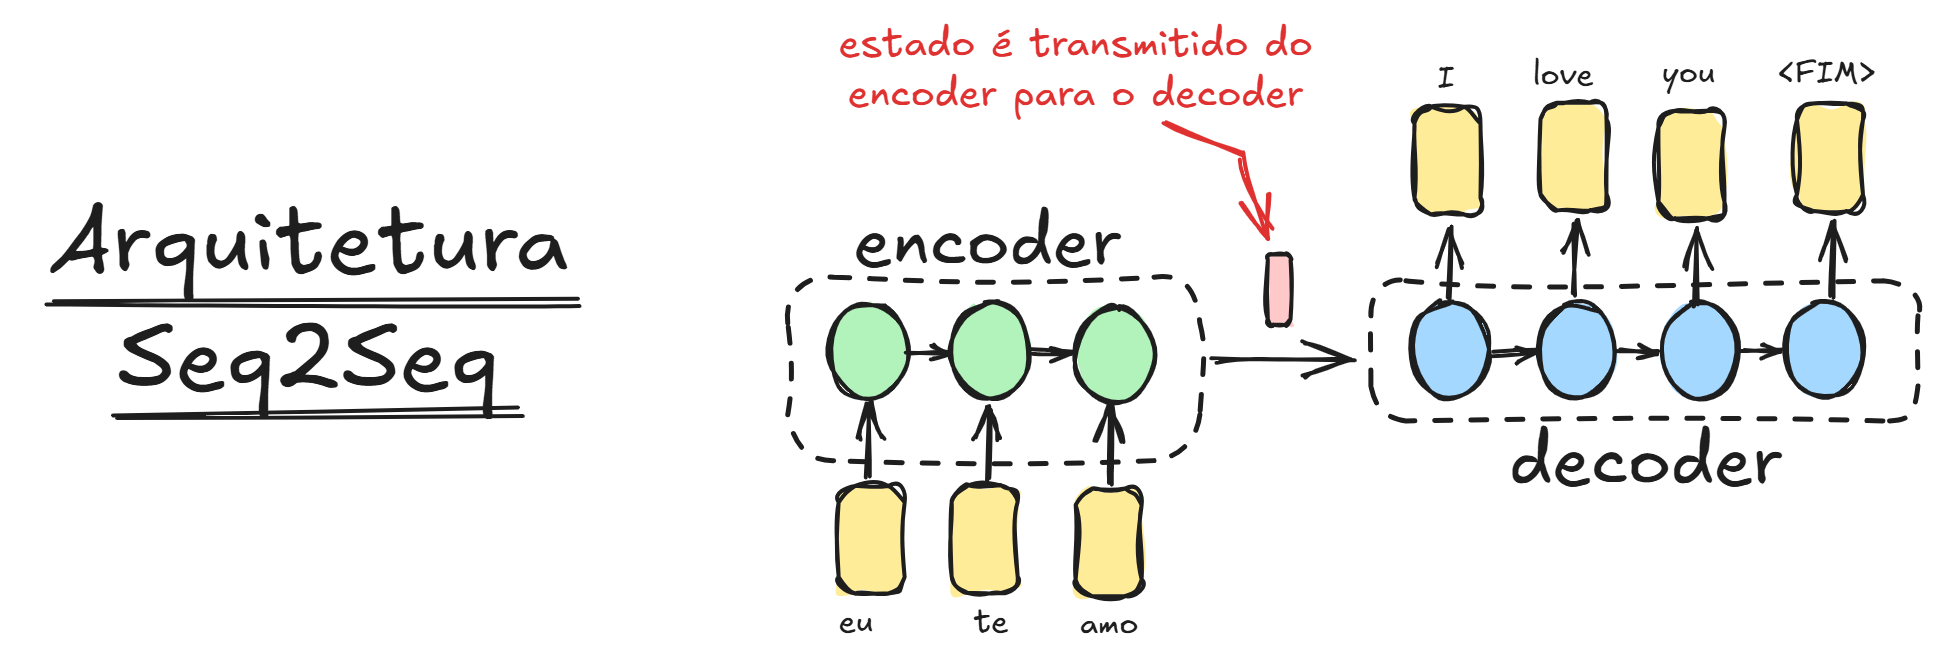

## Preparação do Dataset

Usaremos um mini-dataset de pares de frases inglês-português. Vamos treinar o modelo para prever os textos em português dando como entrada os textos em inglês. O dataset será construído usando um dicionário de poucas palavras e sem utilizar sinais de pontuação.

In [ ]:

texts_en = [
    "I",
    "Hi",
    "No",
    "Yes",
    "You",
    "Hello",
    "John",
    "Today",
    "Goodbye",
    "Please",
    "Thank you",
    "Good morning",
    "Excuse me",
    "I am fine",
    "Who are you",
    "Good afternoon",
    "How are you",
    "Thank you for asking",
    "How am I Good Good Thank you for asking",
]

texts_pt = [
    "Eu",
    "Olá",
    "Não",
    "Sim",
    "Você",
    "Olá",
    "John",
    "hoje",
    "Adeus",
    "Por favor",
    "Obrigado",
    "Bom dia",
    "Com licença",
    "Eu estou bem",
    "Quem é você",
    "Boa tarde",
    "Como você está",
    "Obrigado por perguntar",
    "Como estou Bem Bem Obrigado por perguntar"
]

Como o dataset é extremamente pequeno, vamos aumentá-lo concatenando frases aleatórias da lista acima.

In [ ]:

import numpy as np
from copy import deepcopy

def increase_dataset(orig_en, orig_pt, size=1000):
    augmented_en = deepcopy(orig_en)
    augmented_pt = deepcopy(orig_pt)

    # enquanto o dataset não alcançar o
    # número desejado de amostras
    while len(augmented_en) < size:

        # seleciona o número de frases que serão
        # amostradas entre 2 e 6
        n = np.random.randint(2, 6)

        # seleciona n índices de frases aleatórias
        idx = np.random.randint(0, len(orig_en), size=n)

        # concatena as frases usando espaço e
        # adiciona aos datasets em inglês e português
        augmented_en.append(" ".join([orig_en[i] for i in idx]))
        augmented_pt.append(" ".join([orig_pt[i] for i in idx]))

    return augmented_en, augmented_pt

augmented_en, augmented_pt = increase_dataset(texts_en, texts_pt)

print(augmented_en[-4:])
print(augmented_pt[-4:])

['Hi You Goodbye Today Thank you', 'You Today Today Thank you for asking', 'No Thank you How are you', 'Good afternoon Today Good morning You']
['Olá Você Adeus hoje Obrigado', 'Você hoje hoje Obrigado por perguntar', 'Não Obrigado Como você está', 'Boa tarde hoje Bom dia Você']


A seguir realizamos a tokenização dos textos.

In [ ]:

from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

tokenized_en = [tokenizer(text) for text in augmented_en]
tokenized_pt = [tokenizer(text) for text in augmented_pt]

en_seq_lengths = [len(t) for t in tokenized_en]

print("frase:", augmented_en[0], "tokenizacao:", tokenized_en[0])
print("frase:", augmented_pt[0], "tokenizacao:", tokenized_pt[0])

print("frase:", augmented_en[-1], "tokenizacao:", tokenized_en[-1])
print("frase:", augmented_pt[-1], "tokenizacao:", tokenized_pt[-1])



frase: I tokenizacao: ['i']
frase: Eu tokenizacao: ['eu']
frase: Good afternoon Today Good morning You tokenizacao: ['good', 'afternoon', 'today', 'good', 'morning', 'you']
frase: Boa tarde hoje Bom dia Você tokenizacao: ['boa', 'tarde', 'hoje', 'bom', 'dia', 'você']


### Tokens Especiais

- **`<INICIO>`**: As LSTMs vêem toda a entrada como uma grande sequência de dados. Para indicar que a frase de entrada terminou e que ela deve começar a gerar tokens na língua destino, vamos usar um token especial de `<INICIO>`.

- **`<FIM>`**: O tamanho da sequência de saída não é conhecido dado que uma palavra da entrada pode ser mapeada em várias palavras na saída e vice-versa. O token `<FIM>` será adicionado à todas as frases de saída para que a rede aprenda durante o treinamento a produzir este token como um indicador que a saída terminou.

- **`<PAD>`**: Para tornar o tamanho das sequência uniforme, vamos adicionar um token especial de padding, a saber `<PAD>`.

A célula abaixo adiciona as tags `<INICIO>` e `<FIM>` nos textos em português.

In [ ]:
tokenized_pt = [["<INICIO>"] + t + ["<FIM>"] for t in tokenized_pt]
tokenized_pt[-5:]

[['<INICIO>', 'adeus', 'adeus', 'você', 'eu', '<FIM>'],
 ['<INICIO>', 'olá', 'você', 'adeus', 'hoje', 'obrigado', '<FIM>'],
 ['<INICIO>', 'você', 'hoje', 'hoje', 'obrigado', 'por', 'perguntar', '<FIM>'],
 ['<INICIO>', 'não', 'obrigado', 'como', 'você', 'está', '<FIM>'],
 ['<INICIO>', 'boa', 'tarde', 'hoje', 'bom', 'dia', 'você', '<FIM>']]

A célula abaixo separa as entradas e saídas do decoder (texto em português). A lista de entradas contém o que vai ser passado como entrada a cada instante e a lista saídas contém o que o decoder deverá responder a cada timestep. Aqui, vamos usar uma técnica chamada de **teacher forcing** que consiste em usar os dados reais como entrada para o **decoder** ao invés de suas predições durante o treinamento.

In [ ]:

tokenized_pt_input = [t[:-1] for t in tokenized_pt]
tokenized_pt_output = [t[1:] for t in tokenized_pt]

for i in range(1, 6):
    print("decoder in:", tokenized_pt_input[10 + i], "decoder out:", tokenized_pt_output[10 + i])


decoder in: ['<INICIO>', 'bom', 'dia'] decoder out: ['bom', 'dia', '<FIM>']
decoder in: ['<INICIO>', 'com', 'licença'] decoder out: ['com', 'licença', '<FIM>']
decoder in: ['<INICIO>', 'eu', 'estou', 'bem'] decoder out: ['eu', 'estou', 'bem', '<FIM>']
decoder in: ['<INICIO>', 'quem', 'é', 'você'] decoder out: ['quem', 'é', 'você', '<FIM>']
decoder in: ['<INICIO>', 'boa', 'tarde'] decoder out: ['boa', 'tarde', '<FIM>']


### Padding

A célula abaixo utiliza a técnica de padding para tornar todas as sequências do mesmo tamanho.

In [ ]:
def pad_sequences(texts):
    max_len = max([len(t) for t in texts])

    for idx in range(len(texts)):
        while len(texts[idx]) < max_len:
            texts[idx].append("<PAD>")

pad_sequences(tokenized_en)
pad_sequences(tokenized_pt_input)
pad_sequences(tokenized_pt_output)

print(tokenized_en[12])
print(tokenized_pt_input[12])
print(tokenized_pt_output[12])

['excuse', 'me', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<INICIO>', 'com', 'licença', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['com', 'licença', '<FIM>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


### Transformação dos Tokens em Inteiros

A célula abaixo itera sobre palavras e cria um dicionário mapeando mapas em índices inteiros. Além disto, codificamos os textos subsitutindo as palavras por seus identificadores inteiros.

In [ ]:

word2idx = {}

def encode_texts(lst):
    encoded = []

    # para cada texto
    for text in lst:

        # lista para armazenar a versao
        # codificada do texto
        c = []

        # para cada palavra no texto
        for word in text:
            # se a palavra nao existe no dicionario
            # adiciona e associa com um identificador inteiro
            if word not in word2idx:
                word2idx[word] = len(word2idx)

            # adiciona o identificador da palavra
            # na representacao codificada do texto
            c.append(word2idx[word])

        # adiciona o texto codificado na lista
        encoded.append(c)

    return encoded

encoded_en = encode_texts(tokenized_en)
encoded_pt_input = encode_texts(tokenized_pt_input)
encoded_pt_output = encode_texts(tokenized_pt_output)

print("word2idx:", list(word2idx.items())[:10])
print("\ntexto:", tokenized_en[-1], "\nencoded:", encoded_en[-1])
print("\ntexto:", tokenized_pt_input[-1], "\nencoded:", encoded_pt_input[-1])
print("\ntexto:", tokenized_pt_output[-1], "\nencoded:", encoded_pt_output[-1])


word2idx: [('i', 0), ('<PAD>', 1), ('hi', 2), ('no', 3), ('yes', 4), ('you', 5), ('hello', 6), ('john', 7), ('today', 8), ('goodbye', 9)]

texto: ['good', 'afternoon', 'today', 'good', 'morning', 'you', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'] 
encoded: [12, 20, 8, 12, 13, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

texto: ['<INICIO>', 'boa', 'tarde', 'hoje', 'bom', 'dia', 'você', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'] 
encoded: [24, 43, 44, 30, 35, 36, 29, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

texto: ['boa', 'tarde', 'hoje', 'bom', 'dia', 'você', '<FIM>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'] 
encoded: [43, 44, 30, 35, 36, 29, 48, 

A seguir criamos um dicionário reverso (mapeando os identificadores nas palavras) apenas para que seja possível reconstruir o texto se quisermos. Isto não é necessário para o treinamento.

In [ ]:
idx2word = {idx: word for (word, idx) in word2idx.items()}

list(idx2word.items())[:10]

[(0, 'i'),
 (1, '<PAD>'),
 (2, 'hi'),
 (3, 'no'),
 (4, 'yes'),
 (5, 'you'),
 (6, 'hello'),
 (7, 'john'),
 (8, 'today'),
 (9, 'goodbye')]

### Representação do Dataset usando Tensores do Pytorch

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Convert data to PyTorch Tensors

encoder_input_data = torch.LongTensor(encoded_en).to(device)
decoder_input_data = torch.LongTensor(encoded_pt_input).to(device)
decoder_target_data = torch.LongTensor(encoded_pt_output).to(device)

print("\nFormato encoder_input_data:", encoder_input_data.shape)
print("Formato decoder_input_data:", decoder_input_data.shape)
print("Formato decoder_target_data:", decoder_target_data.shape)


Formato encoder_input_data: torch.Size([1000, 26])
Formato decoder_input_data: torch.Size([1000, 22])
Formato decoder_target_data: torch.Size([1000, 22])


## Definição do Modelo

Ao invés de utilizar *word embeddings* pré-treinados, neste exemplo vamos treinar os embeddings junto com a tarefa de tradução. Para isto, vamos utilizar o componente **`nn.Embedding`** do pytorch. Ele recebe como entrada no construtor o tamanho do vocabulário, o tamanho dos embeddings e o inteiro que representa o símbolo de *padding*.

In [ ]:
import torch.nn as nn

embedding_dim = 16

vocab_size = len(word2idx)
embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2idx['<PAD>'])
embedding

Embedding(49, 16, padding_idx=1)

A seguir, vamos definir o encoder, o decoder e o modelo Seq2Seq que integra os dois. O encoder consiste apenas de uma rede LSTM, enquanto o decoder possui ainda um preditor de tokens. Observe como a classe Seq2Seq passa o estado final do encoder como entrada para o decoder.

In [ ]:

from torch.nn.utils.rnn import pack_padded_sequence

lstm_units = 32

class Encoder(nn.Module):
    def __init__(self, embedding, embedding_dim, lstm_units):
        super(Encoder, self).__init__()
        self.embedding = embedding
        self.lstm = nn.LSTM(embedding_dim, lstm_units, batch_first=True)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.lstm(packed)
        return hidden, cell

encoder = Encoder(embedding, embedding_dim, lstm_units).to(device)
encoder

Encoder(
  (embedding): Embedding(49, 16, padding_idx=1)
  (lstm): LSTM(16, 32, batch_first=True)
)

In [ ]:

class Decoder(nn.Module):
    def __init__(self, embedding, embedding_dim, lstm_units):
        super(Decoder, self).__init__()
        self.embedding = embedding
        self.lstm = nn.LSTM(embedding_dim, lstm_units, batch_first=True)
        self.fc = nn.Linear(lstm_units, vocab_size)

    def forward(self, x, hidden, cell):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        predictions = self.fc(output)
        return predictions, hidden, cell

decoder = Decoder(embedding, embedding_dim, lstm_units).to(device)
decoder

Decoder(
  (embedding): Embedding(49, 16, padding_idx=1)
  (lstm): LSTM(16, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=49, bias=True)
)

In [ ]:

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_input, encoder_lengths, decoder_input):
        hidden, cell = self.encoder(encoder_input, encoder_lengths)
        outputs, _, _ = self.decoder(decoder_input, hidden, cell)
        return outputs

model_seq2seq = Seq2Seq(encoder, decoder).to(device)
model_seq2seq

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(49, 16, padding_idx=1)
    (lstm): LSTM(16, 32, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(49, 16, padding_idx=1)
    (lstm): LSTM(16, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=49, bias=True)
  )
)

## Treinamento

A célula abaixo implementa o loop de treinamento do modelo. Como é um exemplo didático, as passadas `forward` e `backward` usando o dataset inteiro ao invés de utilizar batches. Os modelos são reinicializados para evitar o risco de continuar o treinamento do modelo ao executar a célula mais de uma vez.

In [ ]:

from time import time
import torch.optim as optim

# Recriamos o modelo para evitar o risco de reutilizar pesos já treinados sem querer ao executar a célula várias vezes.
embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2idx['<PAD>'])
encoder = Encoder(embedding, embedding_dim, lstm_units).to(device)
decoder = Decoder(embedding, embedding_dim, lstm_units).to(device)
model_seq2seq = Seq2Seq(encoder, decoder).to(device)

# Define o otimizador
optimizer = optim.Adam(model_seq2seq.parameters(), lr=5e-3)

# Define a função de perda. Note que o argumento ignore_index é usado para informar
# que os tokens de padding devem ser ignorados.
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<PAD>'])

print("\nTreinando o modelo Seq2Seq...")
model_seq2seq.train()

epochs = 200
encoder_lengths = torch.LongTensor(en_seq_lengths)

start = time()

for epoch in range(epochs):
    optimizer.zero_grad()

    # passo forward
    outputs = model_seq2seq(encoder_input_data, encoder_lengths, decoder_input_data)

    # calcula o erro
    output_dim = outputs.shape[-1]
    outputs_for_loss = outputs.view(-1, output_dim)
    target_for_loss = decoder_target_data.view(-1)
    loss = criterion(outputs_for_loss, target_for_loss)

    # computa os gradientes e ajusta os parâmetros
    loss.backward()
    optimizer.step()

    if epoch % max(1, epochs // 20) == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

print(f"Modelo Seq2Seq treinado em {time() - start:.2f}s!")


Treinando o modelo Seq2Seq...
Epoch [1/200], Loss: 3.8768
Epoch [11/200], Loss: 3.3293
Epoch [21/200], Loss: 2.9116
Epoch [31/200], Loss: 2.6734
Epoch [41/200], Loss: 2.3642
Epoch [51/200], Loss: 2.0119
Epoch [61/200], Loss: 1.6882
Epoch [71/200], Loss: 1.4446
Epoch [81/200], Loss: 1.2613
Epoch [91/200], Loss: 1.1141
Epoch [101/200], Loss: 0.9897
Epoch [111/200], Loss: 0.8781
Epoch [121/200], Loss: 0.7811
Epoch [131/200], Loss: 0.6940
Epoch [141/200], Loss: 0.6152
Epoch [151/200], Loss: 0.5517
Epoch [161/200], Loss: 0.4982
Epoch [171/200], Loss: 0.4462
Epoch [181/200], Loss: 0.4062
Epoch [191/200], Loss: 0.3649
Modelo Seq2Seq treinado em 5.54s!


A célula abaixo implementa uma função inferência de forma **autoregressiva**, isto é, as palavras geradas pelo decoder são usadas como entrada no próximo instante. O processo continua enquanto o token de `<FIM>` é gerado ou até um número máximo de passos. Ao final, mostramos as traduções para um conjunto de frases de exemplo.

In [ ]:

def run_inference(input_seq_tensor, length, max_seq_len=20):
    # coloca o modelo em modo de avaliação
    model_seq2seq.eval()

    # não é necessário calcular gradientes durante a inferência
    with torch.no_grad():
        # Passa o texto pelo encoder
        hidden, cell = model_seq2seq.encoder(input_seq_tensor, length)

        # Inicia a tradução usando a tag <INICIO> ocmo entrada
        decoder_input = torch.LongTensor([[word2idx['<INICIO>']]]).to(device)

        # lista para armazenar o texto traduzido
        decoded_sentence = []

        # repete por um número máximo de tokens
        for _ in range(max_seq_len):
            # passa o texto gerado agora pelo decoder e prediz o próximo token
            output, hidden, cell = model_seq2seq.decoder(decoder_input, hidden, cell)

            # seleciona o token com maior probabilidade. O valor 2 é a dimensão onde
            # o argmax deve ser aplicado.
            top_token_id = output.argmax(2)

            # obtem a palavra correspondente ao indice inteiro
            word = idx2word.get(top_token_id.item())

            # Interrompe o loop caso o token de <FIM> seja predito
            if word is None or word == '<FIM>':
                break

            # adiciona o identificador do token na entrada do decoder
            decoder_input = top_token_id.detach()

            # adiciona a palavra predita na lista de saída
            decoded_sentence.append(word)

    # junta as palavras preditas usando espaço como separador.
    return " ".join(decoded_sentence)


def run_translation(test_text):
    tokenized = tokenizer(test_text)
    length = torch.LongTensor([len(tokenized)])
    encoded = encode_texts([tokenized])
    tensor = torch.LongTensor(encoded).to(device)
    decoded = run_inference(tensor, length)

    print(f"EN: '{test_text}'\nPT: '{decoded}'.\n")


run_translation("hello john")
run_translation("good morning")
run_translation("good afternoon john how are you")
run_translation("i am fine thank you for asking")

EN: 'hello john'
PT: 'olá john'.

EN: 'good morning'
PT: 'bom dia'.

EN: 'good afternoon john how are you'
PT: 'boa tarde como você está'.

EN: 'i am fine thank you for asking'
PT: 'eu estou bem obrigado por perguntar'.



## Conclusão

Neste notebook, vimos como utilizar a arquitetura `Seq2Seq` para implementar um sistema simplificado de tradução. Com esta tarefa, concluímos o série de vídeos sobre redes neurais recorrentes. No próximo tópico, vamos estudar a arquitetura Transformer, que são redes neurais baseadas em atenção. Não deixe de realizar as atividades avaliativas para colocar em prática os conteúdos estudados.